In [1]:
!pip install --ignore-installed llvmlite --quiet
!pip install pycaret==2.3.9 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires llvmlite<0.38,>=0.37.0rc1, but you have llvmlite 0.39.1 which is incompatible.


# Import

In [2]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utils

In [3]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = dataset_name2target_name[dataset_name]
  df = get_data(dataset_name, verbose=False).dropna(subset=[target_name])
  X, y = df.drop(target_name, axis=1), df[target_name]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  n_classes = len(set(y))
  X.loc[:, cat_features] = X.loc[:, cat_features].fillna("NULL")
  return X, y, num_features, cat_features, n_classes

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False
    
def binnize(x, nbins=5):
  """Bin numeric values into discrete intervals."""
  bins = x.quantile(np.linspace(0, 1, nbins+1)).to_list()
  bins[0] -= 1e16 
  bins = sorted(set(bins))
  return pd.cut(x=x, bins=bins)

def test_independence(x, y):
  """Test independence between two discrete arrays and return the p-value."""
  crosstab = pd.crosstab(x, y)
  pvalue = chi2_contingency(crosstab, correction=False)[1]
  return pvalue

def get_dependent_columns(X_cat, y, pvalue_threshold=.01):
  """Get the list of columns of X_cat that are not independent from y."""
  pvalues = X_cat.apply(lambda col: test_independence(col, y)).sort_values()
  dependent_columns = pvalues[pvalues<pvalue_threshold].index.to_list()
  return dependent_columns

def get_roc_auc_score(y_true, y_score):
  """Get area under ROC curve."""
  if y_score.shape[1] == 2:
    return roc_auc_score(y_true, np.array(y_score)[:, 1])
  else:
    return roc_auc_score(y_true, y_score, multi_class="ovr")
    
def get_y_proba(roc, n=100000, prevalence=.5):
  """Get two arrays, y and proba, for a given ROC (greater than .5)."""
  n_ones = int(round(n * prevalence))
  n_zeros = n - n_ones
  y = np.array([0] * n_zeros + [1] * n_ones)
  alpha = np.abs(roc - .5) * 2
  proba_zeros = np.linspace(0, 1, n_zeros)
  proba_ones = np.linspace(alpha, 1, n_ones)
  proba = np.concatenate([proba_zeros, proba_ones])
  return y, proba

def test_roc_difference(roc_1, roc_2, n, prevalence, alpha=.05):
  """Test whether the difference between the ROC score of two models on the same test set is significant."""  
  y_universe, proba_universe = get_y_proba(roc=min(roc_1, roc_2), n=100_000, prevalence=prevalence)
  rocs_obs = []
  i = 0
    
  while i < 100:
    try:
      index = np.random.choice(range(len(y_universe)), n, replace=True)
      y_sample, proba_sample = y_universe[index], proba_universe[index]
      rocs_obs.append(roc_auc_score(y_sample, proba_sample))
      i += 1
    except:
      pass
        
  if max(roc_1, roc_2) > np.quantile(rocs_obs, 1-alpha): 
    return True
  else: 
    return False

# Init

In [4]:
dataset_name2target_name = {
  "bank": "deposit",
  "blood": "Class",
  "cancer": "Class",
  "credit": "default",
  "diabetes": "Class variable",
  "electrical_grid": "stabf",
  "employee": "left",
  "heart": "DEATH",
  "heart_disease": "Disease",
  "hepatitis": "Class",
  "income": "income >50K",
  "juice": "Purchase",
  "nba": "TARGET_5Yrs",
  "wine": "type",
  "telescope": "Class",
  "titanic": "Survived",
  "us_presidential_election_results": "party_winner",
  "glass": "Type",
  "iris": "species",
  "poker": "CLASS",
  "questions": "Next_Question",
  "satellite": "Class",
  "CTG": "NSP"
}

dataset_names = list(dataset_name2target_name.keys())

dataset_summary = pd.DataFrame(columns=["dataset", "rows", "cols", "null_perc", "classes"])

results = pd.DataFrame(columns=["dataset", "column", "value", "count", "distr", "roc_general", "roc_specialized"])

# Show summary of datasets

In [5]:
for dataset_name in dataset_names:
            
  X, y, num_features, cat_features, n_classes = get_dataset(dataset_name)
    
  dataset_summary = dataset_summary.append(pd.Series(
    data=[dataset_name, X.shape[0], X.shape[1], X.isna().mean().mean(), len(set(y))],
    index=dataset_summary.columns
  ),ignore_index=True)
    
dataset_summary

,dataset,rows,cols,null_perc,classes
0,bank,45211,16,0.000000,2
1,blood,748,4,0.000000,2
2,cancer,683,9,0.000000,2
3,credit,24000,23,0.000000,2
4,diabetes,768,8,0.000000,2
5,electrical_grid,10000,12,0.000000,2
6,employee,14999,9,0.000000,2
7,heart,200,15,0.000000,2
8,heart_disease,270,13,0.000000,2
9,hepatitis,154,19,0.052290,2


# Run experiments

In [6]:
%%time

for dataset_name in tqdm(dataset_names):
  
  # get data
  X, y, num_features, cat_features, n_classes = get_dataset(dataset_name)

  # split index in training and test set, then train general model on the training set
  ix_train, ix_test = train_test_split(X.index, test_size=.25, stratify=y)
  model_general = CatBoostClassifier().fit(X=X.loc[ix_train,:], y=y.loc[ix_train], cat_features=cat_features, silent=True)
  pred_general = pd.DataFrame(model_general.predict_proba(X.loc[ix_test, :]), index=ix_test, columns=model_general.classes_)

  # create a dataframe where all the columns are categorical: 
  # numerical columns with more than 5 unique values are binnized
  X_cat = X.copy()
  X_cat.loc[:, num_features] = X_cat.loc[:, num_features].fillna(X_cat.loc[:, num_features].median()).apply(lambda col: col if col.nunique() <= 5 else binnize(col)).astype(str)
  
  # get a list of columns that are not (statistically) independent 
  # from y according to chi 2 independence test
  candidate_columns = get_dependent_columns(X_cat, y)
  
  for segmentation_column in candidate_columns:
  
    # get a list of candidate values such that each candidate:
    # - has at least 100 examples in the test set
    # - is not more common than 50%
    vc_test = X_cat.loc[ix_test, segmentation_column].value_counts()
    nu_train = y.loc[ix_train].groupby(X_cat.loc[ix_train, segmentation_column]).nunique()
    nu_test = y.loc[ix_test].groupby(X_cat.loc[ix_test, segmentation_column]).nunique()
    candidate_values = vc_test[(vc_test>=100) & (vc_test/len(ix_test)<.5) & (nu_train==n_classes) & (nu_test==n_classes)].index.to_list()
    
    for value in candidate_values:
      
      # split index in training and test set, then train specialized model 
      # on the portion of the training set that belongs to the segment
      ix_value = X_cat.loc[X_cat.loc[:, segmentation_column] == value, segmentation_column].index    
      ix_train_specialized = list(set(ix_value).intersection(ix_train))
      ix_test_specialized = list(set(ix_value).intersection(ix_test)) 
      model_specialized = CatBoostClassifier().fit(X=X.loc[ix_train_specialized,:], y=y.loc[ix_train_specialized], cat_features=cat_features, silent=True)
      pred_specialized = pd.DataFrame(model_specialized.predict_proba(X.loc[ix_test_specialized, :]), index=ix_test_specialized, columns=model_specialized.classes_)
         
      # compute roc score of both the general model and the specialized model and save them
      roc_auc_score_general = get_roc_auc_score(y.loc[ix_test_specialized], pred_general.loc[ix_test_specialized, :])
      roc_auc_score_specialized = get_roc_auc_score(y.loc[ix_test_specialized], pred_specialized)  
      results = results.append(pd.Series(data=[dataset_name, segmentation_column, value, len(ix_test_specialized), y.loc[ix_test_specialized].value_counts().to_list(), roc_auc_score_general, roc_auc_score_specialized],index=results.columns),ignore_index=True)

100%|██████████| 23/23 [1:00:35<00:00, 158.08s/it]

CPU times: user 3h 8min 58s, sys: 24min 38s, total: 3h 33min 36s
Wall time: 1h 35s


In [7]:
%%time

results["roc_diff_hp"] = results\
  .apply(lambda row: test_roc_difference(
    row["roc_general"], row["roc_specialized"], row["count"], np.mean(row["distr"]) / sum(row["distr"])),axis=1) \
  .replace({False: "not significant", True: "significant"})

CPU times: user 14min 48s, sys: 1.52 ms, total: 14min 48s
Wall time: 14min 48s


In [8]:
results["compare"] = (results["roc_general"] >= results["roc_specialized"]).replace({
  True: "general > specialized",
  False: "specialized > general"
})

# Show results

In [9]:
results["dataset"].nunique()

12

In [10]:
results.sample(frac=1).loc[:, ["dataset", "column", "value", "roc_general", "roc_specialized"]]

,dataset,column,value,roc_general,roc_specialized
565,CTG,LB,"(130.0, 136.0]",1.000000,1.000000
551,CTG,Variance,"(1.0, 4.0]",1.000000,1.000000
10,bank,month,mar,0.745614,0.767909
441,satellite,Attribute27,"(82.0, 96.0]",0.990831,0.983784
7,bank,month,jan,0.956324,0.951858
...,...,...,...,...,...
19,bank,pdays,"(-1.0, 871.0]",0.915821,0.914722
328,wine,fixed acidity,"(-9999999999999996.0, 6.3]",1.000000,1.000000
129,credit,BILL_AMT4,"(960.0, 10851.2]",0.742010,0.713837
433,satellite,Attribute25,"(83.0, 104.0]",0.964684,0.957703


In [11]:
crosstab = pd.crosstab(results["roc_diff_hp"], results["compare"])
crosstab.columns.name = None
crosstab.index.name = None

crosstab

,general > specialized,specialized > general
not significant,454,60
significant,83,4


In [12]:
results[results["roc_diff_hp"] == "significant"].apply(lambda row: row["roc_general"] - row["roc_specialized"], axis=1).mean()

0.02427759355642721

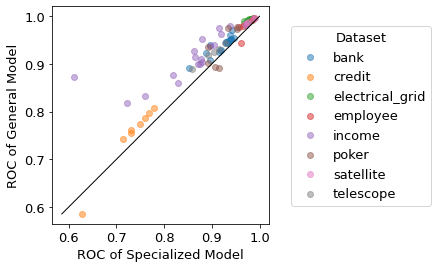

In [13]:
fig, ax = plt.subplots()

for dataset_name in sorted(results["dataset"].unique()):
  results_sub = results[(results["dataset"]==dataset_name) & (results["roc_diff_hp"]=="significant")]
  if len(results_sub) > 1:
    ax.scatter(results_sub["roc_specialized"], results_sub["roc_general"], label=dataset_name, alpha=.5)
    
min_roc = results.loc[:,["roc_general","roc_specialized"]].min().min()
max_roc = results.loc[:,["roc_general","roc_specialized"]].max().max()

ax.plot([min_roc, max_roc], [min_roc, max_roc], color="black", lw=1)
ax.set_ylabel("ROC of General Model", fontsize=13)
ax.set_xlabel("ROC of Specialized Model", fontsize=13)
ax.tick_params(axis="both", which="major", labelsize=13)
ax.set_aspect("equal", "box")

legend = fig.legend(loc="center left", bbox_to_anchor=(.8, .5), fontsize=13)
legend.set_title("Dataset",prop={'size': 13})

fig.savefig("roc_compared.png", dpi=200, bbox_inches="tight")